<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/WiggleGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Wiggle dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander/
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

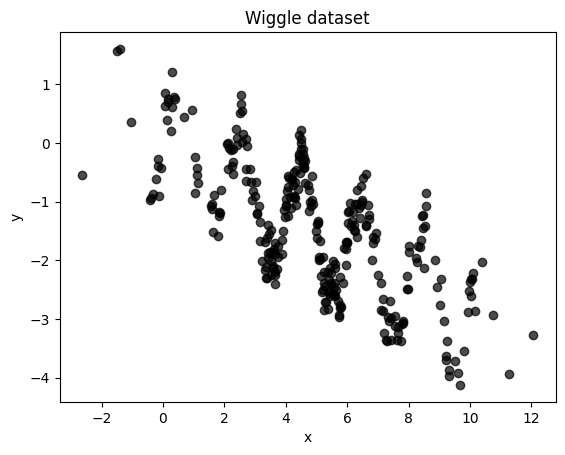

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook
%run "datasets/wiggle.ipynb" # Run the wiggle notebook which is in the same folder(Wiggle dataset)

# Set the seed for NumPy's random number generator
np.random.seed(0)

torch.manual_seed(0)

# Training Data from wiggle

In [3]:
x_wiggle, y_wiggle = x_wiggle, samples # x_wiggle, samples are defined in ../datasets/wiggle.ipynb
print(len(x_wiggle))
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = train_test_split(x_wiggle, y_wiggle, test_size=0.2, random_state=65)
# Transform into tensors
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = (
torch.from_numpy(x_train_wiggle).float(), torch.from_numpy(x_test_wiggle).float(),
torch.from_numpy(y_train_wiggle).float(), torch.from_numpy(y_test_wiggle).float())

# Move to GPU if possible
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = (
    x_train_wiggle.to(device), x_test_wiggle.to(device), y_train_wiggle.to(device), y_test_wiggle.to(device)
)

# Different training sizes
sizes_list = [5000,10000,15000,20000] # Choose how many points
x_sizes = [] # List of different sized training points (x)
y_sizes = [] # List of different sized trainig points  (y)
for i in sizes_list:
  x_sizes.append(x_train_wiggle[:i])
  y_sizes.append(y_train_wiggle[:i])



training_x = x_train_wiggle[:500]
training_y = y_train_wiggle[:500]

50000


# Define the KISS-GP Model

In [4]:
KISSGP_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_wiggle = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_wiggle = gpytorch.kernels.MaternKernel() # Kernel
KISSGP_model_wiggle = KISSGP(training_x,
                             training_y,
                             KISSGP_likelihood_wiggle,
                             KISSGP_mean_wiggle,
                             KISSGP_kernel_wiggle) # KISSGP defined in utils/Models.ipynb
KISSGP_model_wiggle = KISSGP_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


8.266740322113037


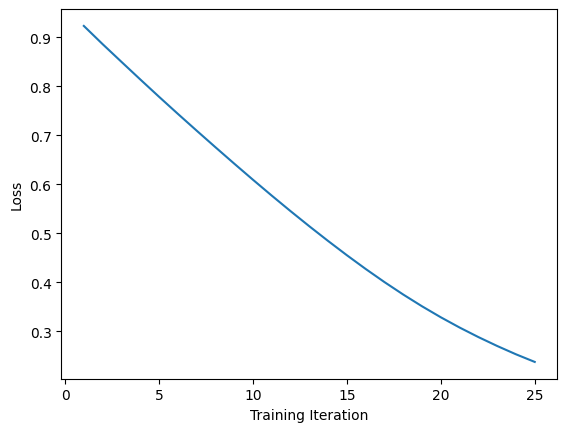

In [5]:



train_time_KISSGP_wiggle = train(KISSGP_model_wiggle,
                                 KISSGP_likelihood_wiggle,
                                 training_x, training_y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
print(train_time_KISSGP_wiggle)



# Compare Different Train Times


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


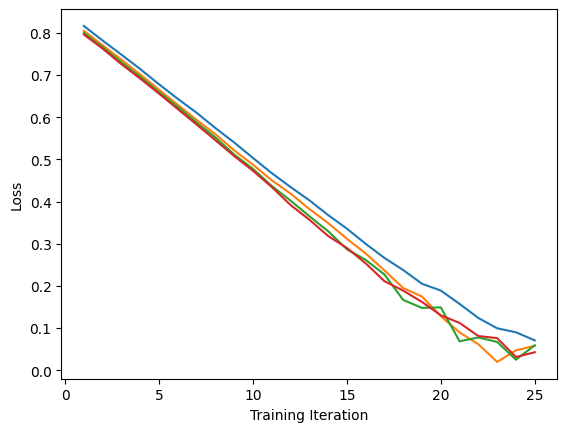

In [6]:
training_times_KISSGP = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  x,y = x.to(device), y.to(device)
  KISSGP_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  KISSGP_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  KISSGP_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  KISSGP_model_wiggle_test = KISSGP(x,
                             y,
                             KISSGP_likelihood_wiggle_test,
                             KISSGP_mean_wiggle_test,
                             KISSGP_kernel_wiggle_test)

  KISSGP_model_wiggle_test = KISSGP_model_wiggle_test.to(device)
  train_time_KISSGP_wiggle_test = train(KISSGP_model_wiggle_test,
                                 KISSGP_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_KISSGP.append(train_time_KISSGP_wiggle_test)

# Plot KISS-GP Model

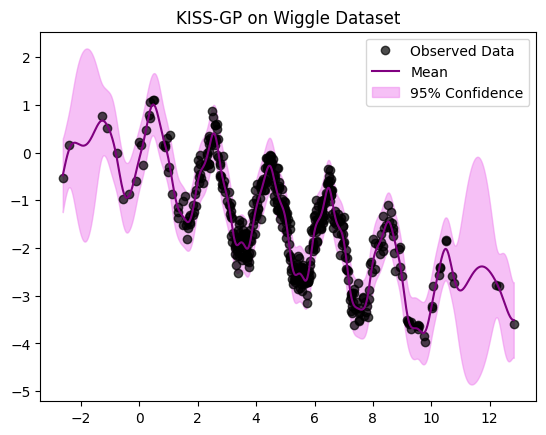

In [7]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, KISSGP_model_wiggle, KISSGP_likelihood_wiggle, "KISS-GP on Wiggle Dataset")

# Predict and Evaluate KISS-GP Model

In [8]:
# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle,
                                      KISSGP_likelihood_wiggle,
                                      x_test_wiggle) # predict is defined in utils/functions.ipynb

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle, KISSGP_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_wiggle, NLPD_KISSGP_wiggle, PICP_KISSGP_wiggle, MPIW_KISSGP_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_KISSGP_wiggle.mean,
      predictions_KISSGP_wiggle.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_wiggle)
  print("NLPD KISS-GP: ",NLPD_KISSGP_wiggle)
  print("PICP KISS-GP: ",PICP_KISSGP_wiggle)
  print("MPIW KISS-GP: ",MPIW_KISSGP_wiggle)
  print("Time KISS-GP: ", train_time_KISSGP_wiggle)

RMSE KISS-GP:  0.87466925
NLPD KISS-GP:  3.561647653579712
PICP KISS-GP:  0.5533
MPIW KISS-GP:  1.2375221
Time KISS-GP:  8.266740322113037


# Variational Model

In [45]:
variational_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_wiggle = gpytorch.means.ConstantMean()
variational_kernel_wiggle = gpytorch.kernels.MaternKernel()
n_inducing_points = int(len(training_x)/10) # Choose how many inducing points
inducing_points = training_x[torch.randperm(training_x.size(0))[:n_inducing_points]]
variational_model_wiggle = variationalGP(variational_likelihood_wiggle,
                                         variational_mean_wiggle,
                                         variational_kernel_wiggle,
                                         inducing_points) # .variationalGP defined in utils/models.ipynb
variational_model_wiggle = variational_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Variational Model

Training Time:  0.3879978656768799


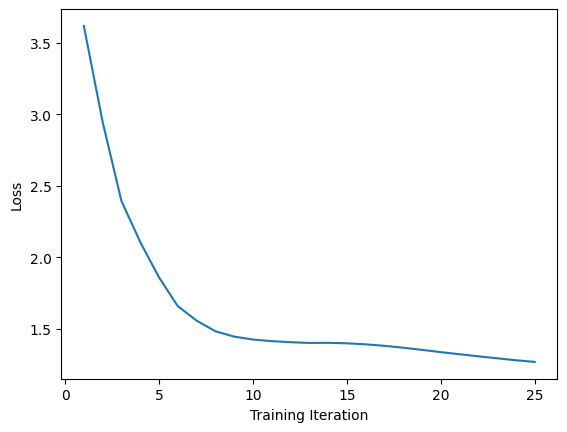

In [46]:
train_time_variational_wiggle = train_ELBO(variational_model_wiggle,
                                           variational_likelihood_wiggle,
                                           training_x, training_y,
                                           training_iter= 25) # train is defined in utils/functions.ipynb
print("Training Time: ",train_time_variational_wiggle)



# Compare Different Training Times

5000
10000
15000
20000


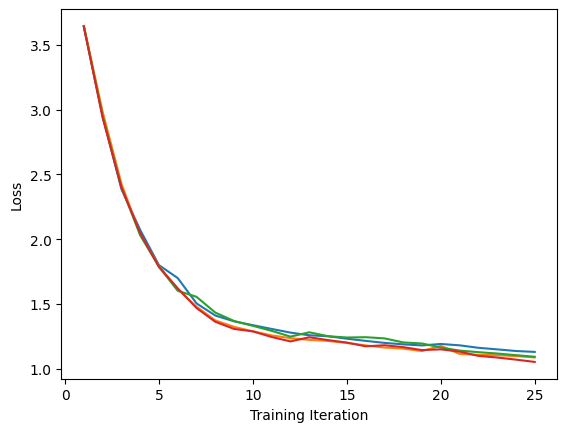

In [47]:
training_times_variational = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  print(len(x))
  n_inducing_points = int(len(x)/10) # Choose how many inducing points
  inducing_points = x[torch.randperm(x.size(0))[:n_inducing_points]]
  inducing_points = inducing_points.to(device)

  variational_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  variational_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  variational_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  variational_model_wiggle_test = variationalGP(
                             variational_likelihood_wiggle_test,
                             variational_mean_wiggle_test,
                             variational_kernel_wiggle_test,
                             inducing_points)

  variational_model_wiggle_test = variational_model_wiggle_test.to(device)
  train_time_variational_wiggle_test = train_ELBO(variational_model_wiggle_test,
                                 variational_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_variational.append(train_time_variational_wiggle_test)

# Plot Variational Model

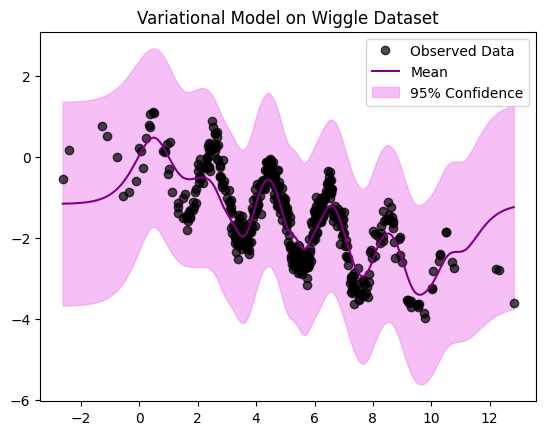

In [12]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, variational_model_wiggle, variational_likelihood_wiggle, "Variational Model on Wiggle Dataset")

# Predict and Evaluate Variational Model

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_wiggle = predict(variational_model_wiggle, variational_likelihood_wiggle, x_test_wiggle)

  RMSE_variational_wiggle, NLPD_variational_wiggle, PICP_variational_wiggle, MPIW_variational_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_variational_wiggle.mean,
      predictions_variational_wiggle.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_wiggle)
  print("NLPD variational Model: ",NLPD_variational_wiggle)
  print("PICP variational Model: ",PICP_variational_wiggle)
  print("MPIW variational Model: ",MPIW_variational_wiggle)
  print("Time variational Model: ", train_time_variational_wiggle)

RMSE variational Model:  0.54754436
NLPD variational Model:  1.130121111869812
PICP variational Model:  0.9953
MPIW variational Model:  4.31058
Time variational Model:  0.358978271484375


# State Space Model Optimized

In [14]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_wiggle)
all_points = jnp.concatenate([training_x.numpy(), x_test_wiggle.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs_wiggle = all_points[temporal_order]
ss_ys_wiggle = jnp.concatenate([training_y.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]

# Compute the equivalent SS model
t0 = min(training_x).numpy().item()
dts_wiggle = jnp.diff(ss_xs_wiggle, prepend=t0)

In [15]:
# Calculate ell and sigma
opt_ell_wiggle, opt_sigma_wiggle, train_time_SSOP_wiggle = train_SSGP(training_x, training_y, x_test_wiggle, ell=1, sigma=1, training_iterations=25)

In [16]:
mfs, vfs, mps, vps, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, opt_ell_wiggle, opt_sigma_wiggle, m0=0, v0=1)
mss, vss = kalmanSmoothing(opt_ell_wiggle, dts_wiggle, mfs, vfs, mps, vps)
ssop_posterior_mean_wiggle = mss[jnp.isnan(ss_ys_wiggle)]
ssop_posterior_var_wiggle = vss[jnp.isnan(ss_ys_wiggle)]


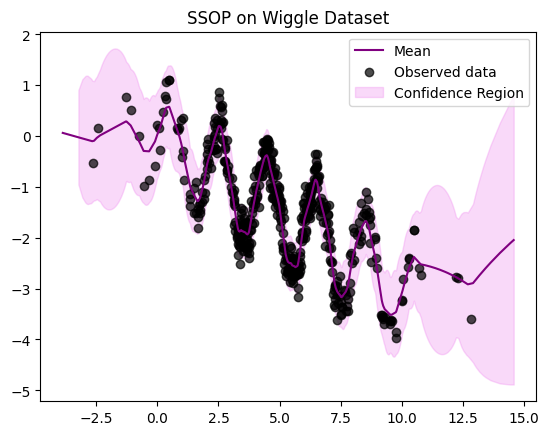

In [17]:
# Plot SSOP
plot_SSGP(training_x, training_y, x_test_wiggle, ssop_posterior_mean_wiggle, ssop_posterior_var_wiggle, title= "SSOP on Wiggle Dataset")

# Evaluate SSOP

In [49]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Order y_test, x_test
  temporal_order = jnp.argsort(x_test_wiggle.numpy())
  y_test_temporal_order = y_test_wiggle.numpy()[temporal_order]
  x_test_temporal_order = x_test_wiggle.numpy()[temporal_order]

  RMSE_SSOP_wiggle, NLPD_SSOP_wiggle, PICP_SSOP_wiggle, MPIW_SSOP_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(ssop_posterior_mean_wiggle)),
      torch.tensor(np.array(np.abs(ssop_posterior_var_wiggle))))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSOP Model: ",RMSE_SSOP_wiggle)
  print("NLPD SSOP Model: ",NLPD_SSOP_wiggle)
  print("PICP SSOP Model: ",PICP_SSOP_wiggle)
  print("MPIW SSOP Model: ",MPIW_SSOP_wiggle)
  print("Time SSOP Model: ", train_time_SSOP_wiggle)

RMSE SSOP Model:  0.33237717
NLPD SSOP Model:  0.21760061383247375
PICP SSOP Model:  0.9479
MPIW SSOP Model:  1.2108337
Time SSOP Model:  13.640568256378174


# Compare Different Training Times

In [19]:
training_times_SSJX = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  x,y = x.to(device), y.to(device)

  _, _, train_time_SSJX_wiggle_test = train_SSGP(x,
                                                    y,
                                                    x_test_wiggle,
                                                    ell=1,
                                                    sigma=1,
                                                    training_iterations=25)
  training_times_SSJX.append(train_time_SSJX_wiggle_test)

SS with PyTorch

In [20]:
# Train with pytorch instead

# Calculate ell and sigma

#opt_ell_wiggle_torch, opt_sigma_wiggle_torch, train_time_SSPY_wiggle = train_SSGP_torch(training_x,
 #                                                                                           training_y,
 #                                                                                           x_test_wiggle,
 #                                                                                           ell=1,
 #                                                                                           sigma=1,
 #                                                                                           training_iterations=25)
# Convert them to numpy arrays
# Assume tensor is on GPU
#opt_ell_wiggle_pytorch = opt_ell_wiggle_torch.to('cpu')
#opt_sigma_wiggle_pytorch = opt_sigma_wiggle_torch.to('cpu')

#opt_ell_wiggle_numpy = opt_ell_wiggle_pytorch.numpy()
#opt_sigma_wiggle_numpy = opt_sigma_wiggle_pytorch.numpy()
# Calculate mean and variance

#mfs_torch, vfs_torch, mps_torch, vps_torch, _ = kalmanFilter(ss_ys_wiggle,
#                                                             dts_wiggle,
#                                                             opt_ell_wiggle_numpy,
#                                                             opt_sigma_wiggle_numpy,
#                                                             m0=0, v0=1)
#mss_torch, vss_torch = kalmanSmoothing(opt_ell_wiggle_numpy, dts_wiggle, mfs_torch, vfs_torch, mps_torch, vps_torch)
#sspy_posterior_mean_wiggle = mss_torch[jnp.isnan(ss_ys_wiggle)]
#sspy_posterior_var_wiggle = vss_torch[jnp.isnan(ss_ys_wiggle)]



IndentationError: unexpected indent (<ipython-input-20-cbc240c392be>, line 21)

# Compare Different Training Times

In [ ]:
#training_times_SSPY = [] # Keep track of the times
#for x,y  in zip(x_sizes, y_sizes):
#  x,y = x.to(device), y.to(device)

#  _, _, train_time_SSPY_wiggle_test = train_SSGP_torch(x,
 #                                                   y,
 #                                                   x_test_wiggle,
 #                                                   ell=1,
 #                                                   sigma=1,
 #                                                   training_iterations=25)
 # training_times_SSPY.append(train_time_SSPY_wiggle_test)

In [ ]:
# Plot SSPY
#plot_SSGP(training_x, training_y, x_test_wiggle, sspy_posterior_mean_wiggle, sspy_posterior_var_wiggle, title= "SSPY on Wiggle Dataset")

In [ ]:

#with torch.no_grad(), gpytorch.settings.fast_pred_var():
#  RMSE_SSPY_wiggle, NLPD_SSPY_wiggle, PICP_SSPY_wiggle, MPIW_SSPY_wiggle = error_metrics(
#      torch.tensor(x_test_temporal_order),
#      torch.tensor(y_test_temporal_order),
#      torch.tensor(np.array(sspy_posterior_mean_wiggle)),
#      torch.tensor(np.array(sspy_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
#  print("RMSE SSPY Model: ",RMSE_SSPY_wiggle)
#  print("NLPD SSPY Model: ",NLPD_SSPY_wiggle)
#  print("PICP SSPY Model: ",PICP_SSPY_wiggle)
#  print("MPIW SSPY Model: ",MPIW_SSPY_wiggle)
#  print("Time SSPY Model: ", train_time_SSPY_wiggle)

# State Space Model, without optimizer

In [21]:
# Pick hyperparameters on your own:
ell = 3
sigma = 1

start_time = time.time()
mfs2, vfs2, mps2, vps2, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, ell, sigma, m0=0, v0=1)
mss2, vss2 = kalmanSmoothing(ell, dts_wiggle, mfs2, vfs2, mps2, vps2)
sswo_posterior_mean_wiggle = mss2[jnp.isnan(ss_ys_wiggle)]
sswo_posterior_var_wiggle = vss2[jnp.isnan(ss_ys_wiggle)]
end_time = time.time()
train_time_SSWO_wiggle = end_time-start_time

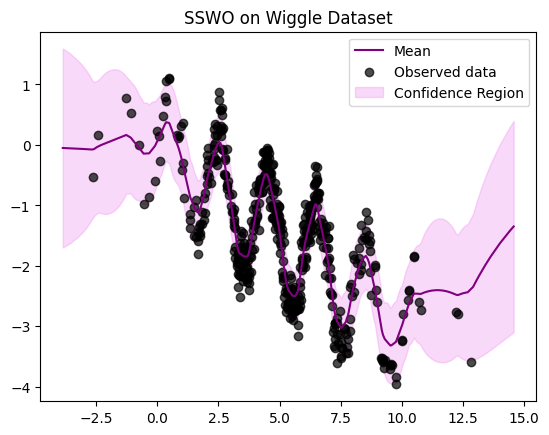

In [22]:
plot_SSGP(training_x, training_y, x_test_wiggle, sswo_posterior_mean_wiggle, sswo_posterior_var_wiggle, title= "SSWO on Wiggle Dataset")

# Evaluate SSWO

In [23]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():

  RMSE_SSWO_wiggle, NLPD_SSWO_wiggle, PICP_SSWO_wiggle, MPIW_SSWO_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sswo_posterior_mean_wiggle)),
      torch.tensor(np.array(sswo_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSWO Model: ",RMSE_SSWO_wiggle)
  print("NLPD SSWO Model: ",NLPD_SSWO_wiggle)
  print("PICP SSWO Model: ",PICP_SSWO_wiggle)
  print("MPIW SSWO Model: ",MPIW_SSWO_wiggle)
  print("Time SSWO Model: ", train_time_SSWO_wiggle)

RMSE SSWO Model:  0.37863886
NLPD SSWO Model:  0.4554111361503601
PICP SSWO Model:  0.8437
MPIW SSWO Model:  0.982783
Time SSWO Model:  0.2420499324798584


# Inducing Points Model

In [24]:
inducing_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_wiggle = gpytorch.means.ConstantMean() # Mean
inducing_kernel_wiggle = gpytorch.kernels.MaternKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(training_x.size(0))
# Select N random rows
inducing_points_amount = int(len(training_x)/10) # Choose how many inducing points
inducing_points = training_x[indices][:inducing_points_amount]
inducing_model_wiggle = inducingGP(training_x,
                                 training_y,
                                 inducing_likelihood_wiggle,
                                 inducing_mean_wiggle,
                                 inducing_kernel_wiggle,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

# Train Inducing Points Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


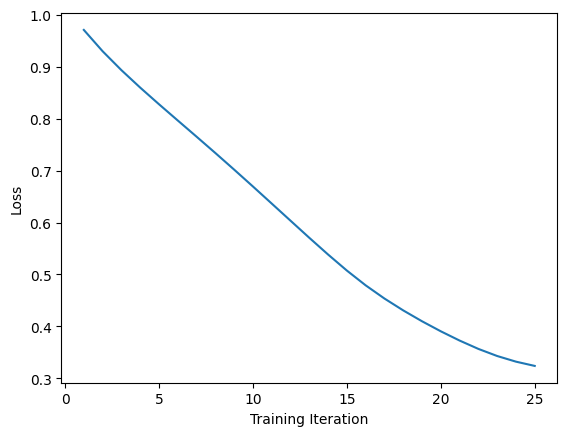

In [25]:
train_time_inducing_wiggle = train(inducing_model_wiggle,
                          inducing_likelihood_wiggle,
                          training_x,
                          training_y,
                          training_iter= 25) # train is defined in utils/functions.ipynb

# Compare Different Training Times

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


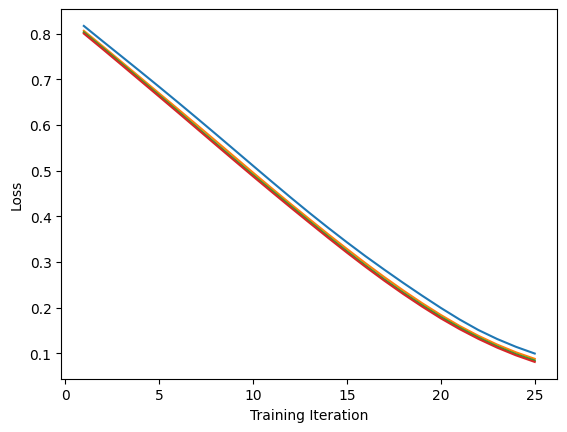

In [26]:
training_times_inducing = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  inducing_points_amount = int(len(x)/10) # Choose how many inducing points
  inducing_points = x[indices][:inducing_points_amount]
  x,y = x.to(device), y.to(device)

  inducing_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  inducing_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  inducing_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  inducing_model_wiggle_test = inducingGP(x,
                             y,
                             inducing_likelihood_wiggle_test,
                             inducing_mean_wiggle_test,
                             inducing_kernel_wiggle_test,
                             inducing_points)

  inducing_model_wiggle_test = inducing_model_wiggle_test.to(device)
  train_time_inducing_wiggle_test = train(inducing_model_wiggle_test,
                                 inducing_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_inducing.append(train_time_inducing_wiggle_test)

# Plot Inducing Points Model

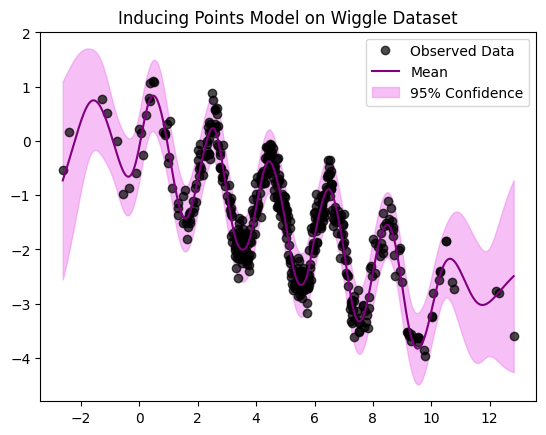

In [27]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, inducing_model_wiggle, inducing_likelihood_wiggle, "Inducing Points Model on Wiggle Dataset")

# Predict and Evaluate Inducing Points Model

In [28]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_wiggle = predict(inducing_model_wiggle, inducing_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_inducing_wiggle, NLPD_inducing_wiggle, PICP_inducing_wiggle, MPIW_inducing_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_inducing_wiggle.mean,
      predictions_inducing_wiggle.variance)# error_metrics defined in utils/functions.ipynb



  print("RMSE inducing: ",RMSE_inducing_wiggle)
  print("NLPD inducing: ",NLPD_inducing_wiggle)
  print("PICP inducing: ",PICP_inducing_wiggle)
  print("MPIW inducing: ",MPIW_inducing_wiggle)
  print("Time inducing: ", train_time_inducing_wiggle)

RMSE inducing:  0.3328089
NLPD inducing:  0.22038352489471436
PICP inducing:  0.9539
MPIW inducing:  1.2206385
Time inducing:  0.23383283615112305


# Exact Gaussian Process Model

# Define The Model

In [29]:
exact_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_wiggle = gpytorch.means.ConstantMean() # Mean
exact_kernel_wiggle = gpytorch.kernels.MaternKernel() # Kernel
exact_model_wiggle = exactGP(training_x,
                             training_y,
                             exact_likelihood_wiggle,
                             exact_mean_wiggle,
                             exact_kernel_wiggle) # exactGP defined in utils/Models.ipynb
exact_model_wiggle = exact_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Model

0.5999569892883301


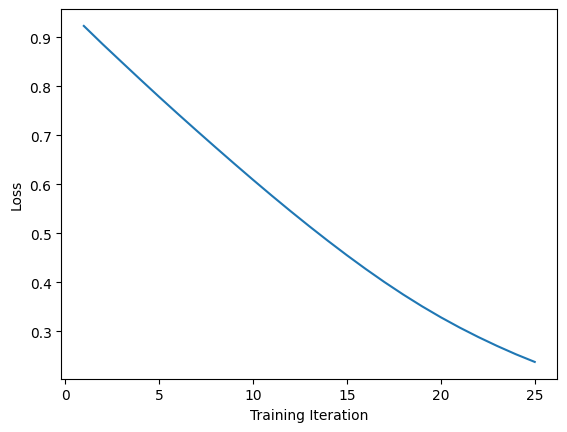

In [30]:
train_time_exact_wiggle = train(exact_model_wiggle,
                                 exact_likelihood_wiggle,
                                 training_x, training_y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
print(train_time_exact_wiggle)

# Compare Different Training Times

5000
10000
15000
20000


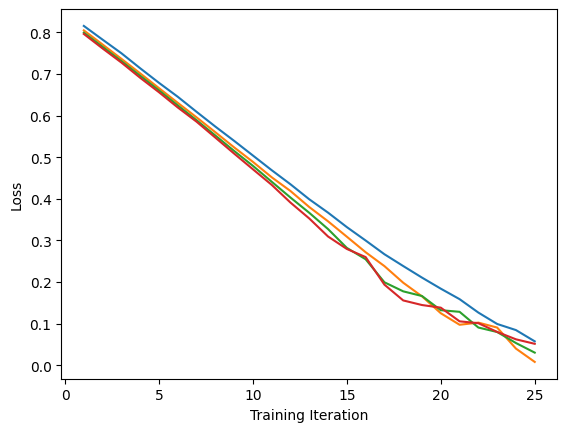

In [31]:
training_times_exact = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  print(len(x))
  x,y = x.to(device), y.to(device)

  exact_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  exact_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  exact_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  exact_model_wiggle_test = exactGP(x,
                             y,
                             exact_likelihood_wiggle_test,
                             exact_mean_wiggle_test,
                             exact_kernel_wiggle_test)

  exact_model_wiggle_test = exact_model_wiggle_test.to(device)
  train_time_exact_wiggle_test = train(exact_model_wiggle_test,
                                 exact_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_exact.append(train_time_exact_wiggle_test)

# Plot Exact GP

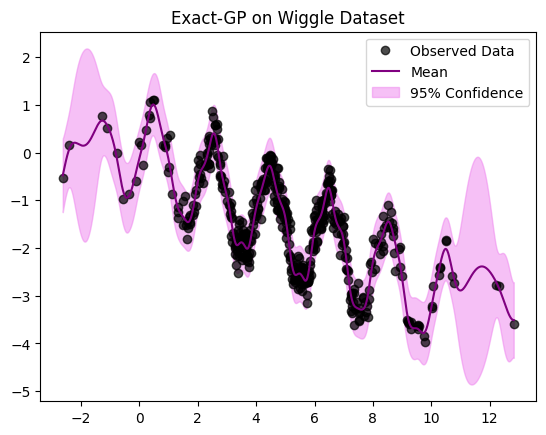

In [32]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, exact_model_wiggle, exact_likelihood_wiggle, "Exact-GP on Wiggle Dataset")

# Evaluate Exact GP

In [33]:
# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_wiggle = predict(exact_model_wiggle,
                                      exact_likelihood_wiggle,
                                      x_test_wiggle) # predict is defined in utils/functions.ipynb

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_wiggle = predict(exact_model_wiggle, exact_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_exact_wiggle, NLPD_exact_wiggle, PICP_exact_wiggle, MPIW_exact_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_exact_wiggle.mean,
      predictions_exact_wiggle.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_exact_wiggle)
  print("NLPD KISS-GP: ",NLPD_exact_wiggle)
  print("PICP KISS-GP: ",PICP_exact_wiggle)
  print("MPIW KISS-GP: ",MPIW_exact_wiggle)
  print("Time KISS-GP: ", train_time_exact_wiggle)

RMSE KISS-GP:  0.3200426
NLPD KISS-GP:  0.14601799845695496
PICP KISS-GP:  0.9731
MPIW KISS-GP:  1.2375367
Time KISS-GP:  0.5999569892883301


# Display Results

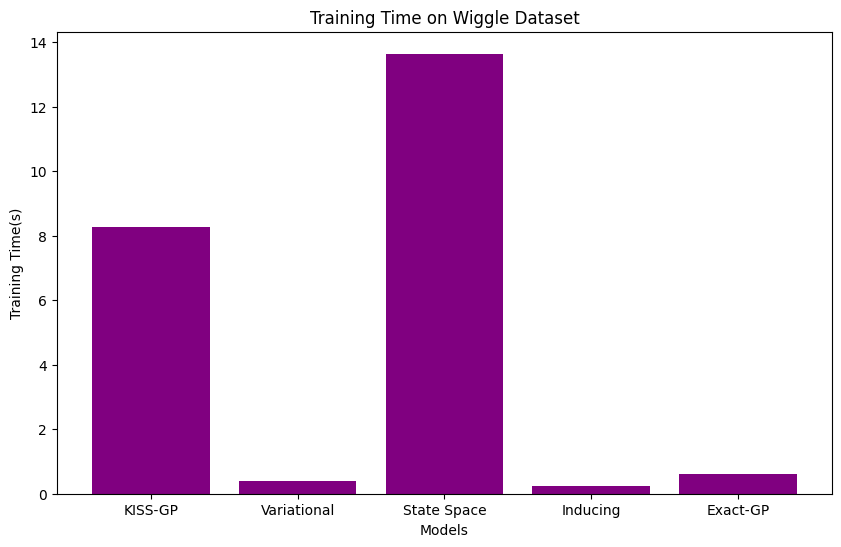

In [53]:
# Training times
models = ["KISS-GP", "Variational", "State Space", "Inducing", "Exact-GP"]
times_wiggle = [train_time_KISSGP_wiggle, train_time_variational_wiggle, train_time_SSOP_wiggle, train_time_inducing_wiggle, train_time_exact_wiggle]
plot_bar(models, times_wiggle, "Training Time on Wiggle Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

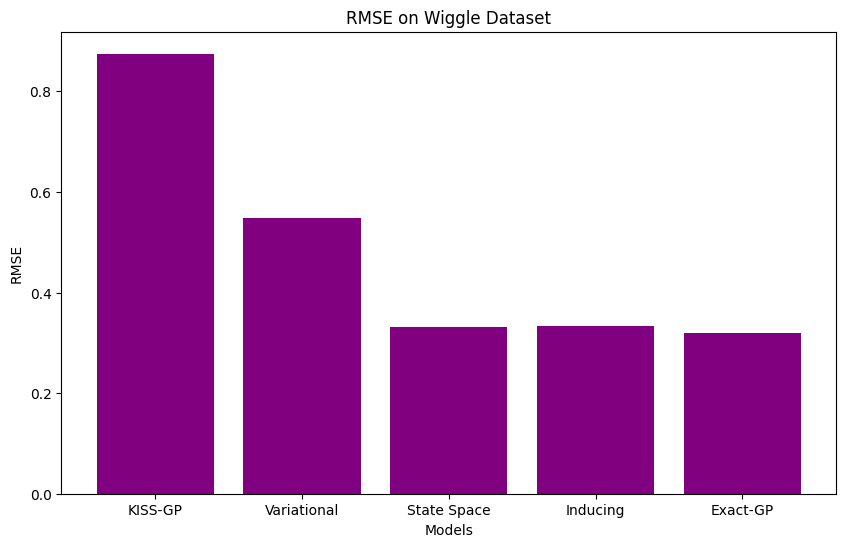

In [54]:
# RMSE
models = ["KISS-GP", "Variational", "State Space", "Inducing", "Exact-GP"]
RMSE_wiggle = [RMSE_KISSGP_wiggle, RMSE_variational_wiggle, RMSE_SSOP_wiggle, RMSE_inducing_wiggle, RMSE_exact_wiggle]
plot_bar(models, RMSE_wiggle, "RMSE on Wiggle Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

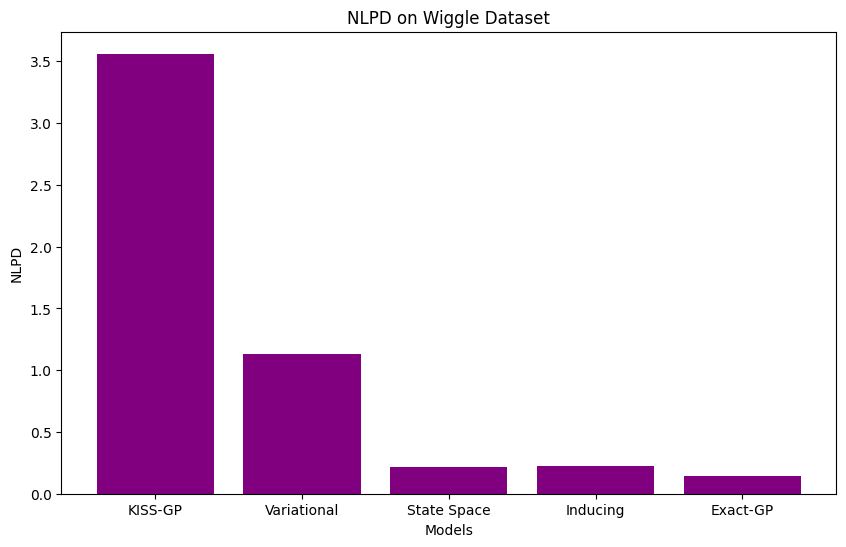

In [55]:
# NLPD
models = ["KISS-GP", "Variational", "State Space", "Inducing", "Exact-GP"]
NLPD_wiggle = [NLPD_KISSGP_wiggle, NLPD_variational_wiggle, NLPD_SSOP_wiggle, NLPD_inducing_wiggle, NLPD_exact_wiggle]
plot_bar(models, NLPD_wiggle, "NLPD on Wiggle Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

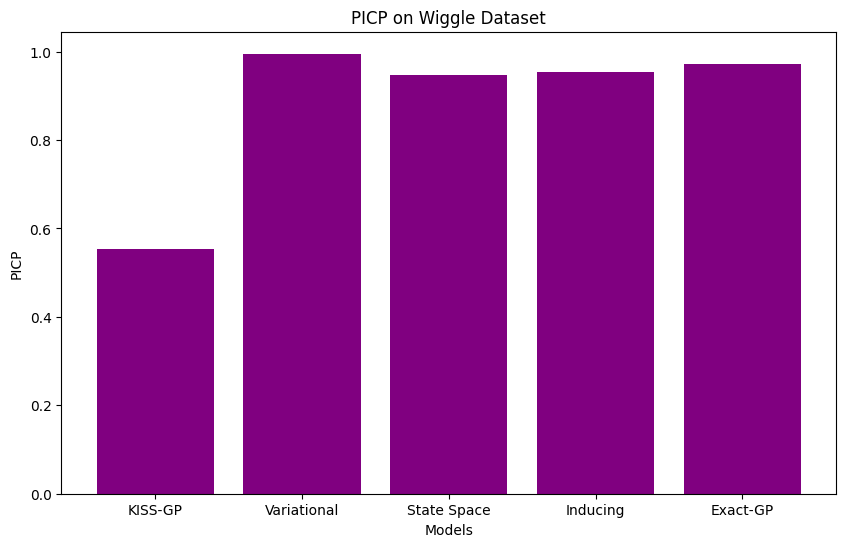

In [56]:
# PICP
models = ["KISS-GP", "Variational", "State Space", "Inducing", "Exact-GP"]
PICP_wiggle = [PICP_KISSGP_wiggle, PICP_variational_wiggle, PICP_SSOP_wiggle, PICP_inducing_wiggle, PICP_exact_wiggle]
plot_bar(models, PICP_wiggle, "PICP on Wiggle Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb


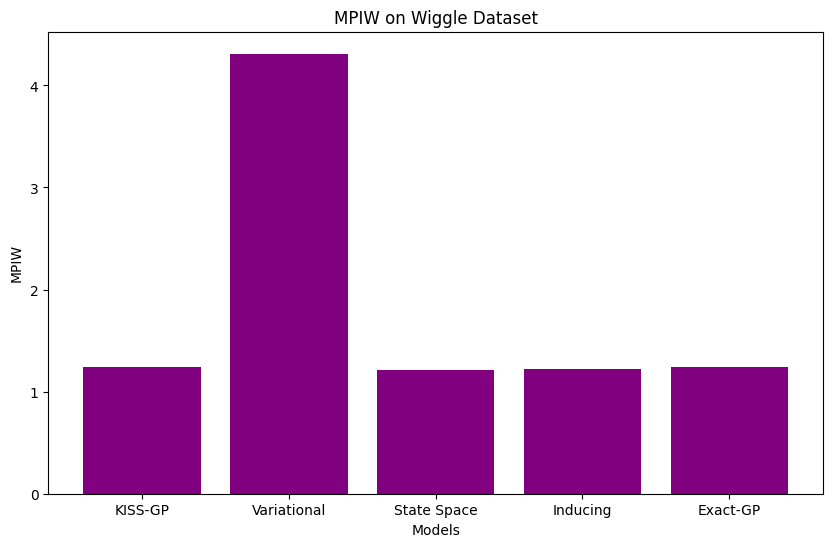

In [57]:
# MPIW
models = ["KISS-GP", "Variational", "State Space", "Inducing", "Exact-GP"]
MPIW_wiggle = [MPIW_KISSGP_wiggle, MPIW_variational_wiggle, MPIW_SSOP_wiggle, MPIW_inducing_wiggle, MPIW_exact_wiggle]
plot_bar(models, MPIW_wiggle, "MPIW on Wiggle Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

# Summarize for report

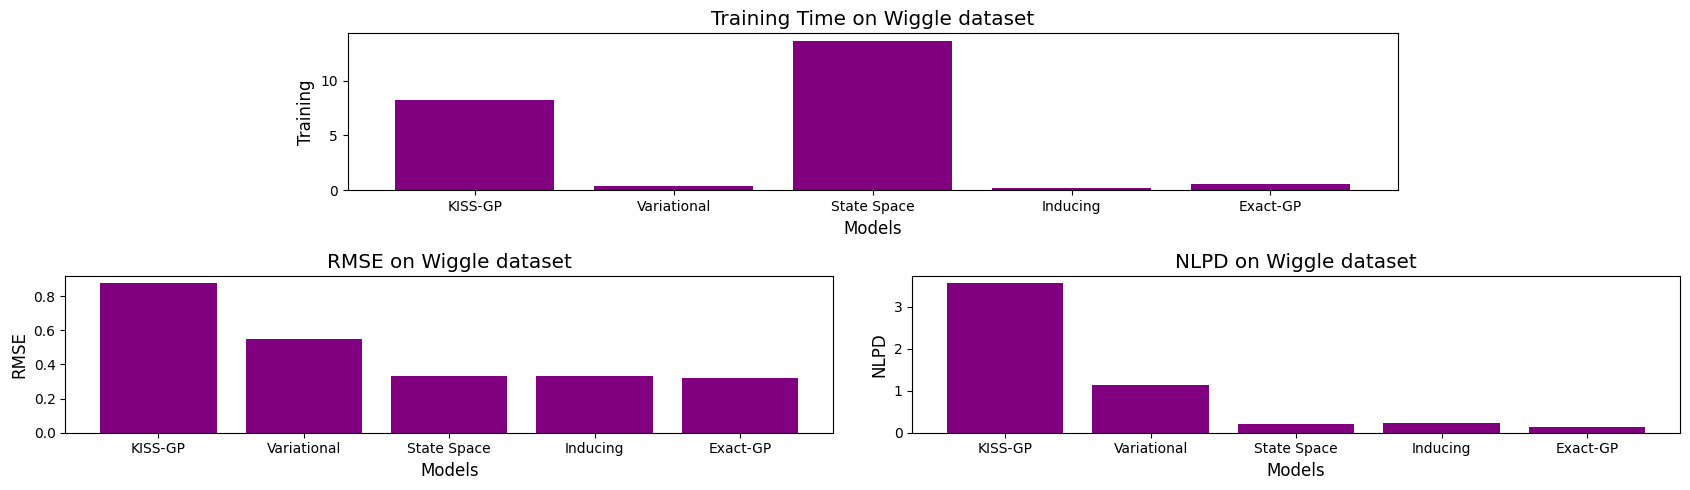

In [58]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])  # Spans columns 0-1
ax2 = fig.add_subplot(gs[1, 0:3])  # Spans columns 2-3
ax3 = fig.add_subplot(gs[1, 3:6])  # Spans columns 4-5

axes = [ax1, ax2, ax3]  # List of axes
data = [times_wiggle, RMSE_wiggle, NLPD_wiggle]  # Replace with your data
titles = ["Training Time on Wiggle dataset", "RMSE on Wiggle dataset", "NLPD on Wiggle dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_wiggle1.pdf")
plt.show()

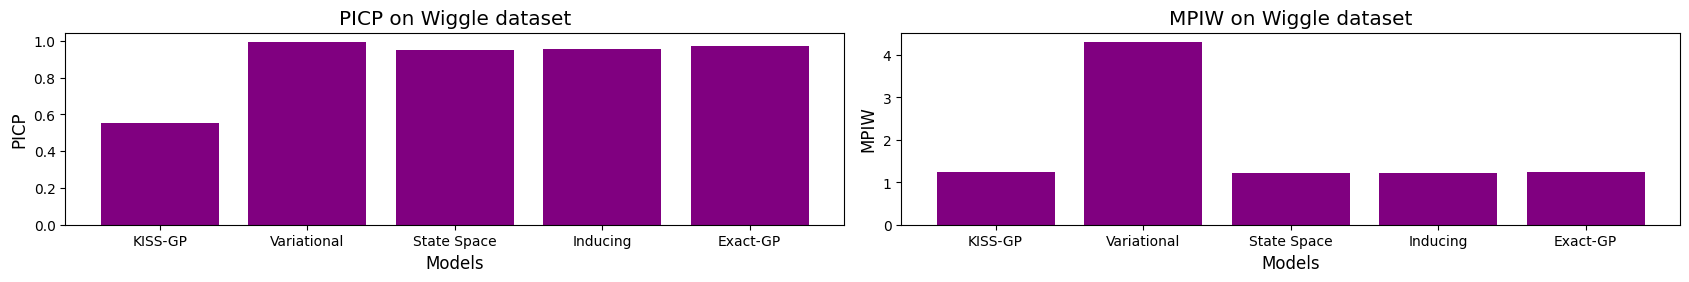

In [59]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])  # Spans columns 0-1
ax2 = fig.add_subplot(gs[0, 3:6])  # Spans columns 2-3


axes = [ax1, ax2]  # List of axes
data = [PICP_wiggle, MPIW_wiggle]  # Replace with your data
titles = ["PICP on Wiggle dataset", "MPIW on Wiggle dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_wiggle2.pdf")
plt.show()

<ipython-input-48-c17a7a91893c>:59: RuntimeWarning: invalid value encountered in sqrt
  lower_bound_SS = ssop_posterior_mean_wiggle-(1.96*(np.sqrt(ssop_posterior_var_wiggle)))
<ipython-input-48-c17a7a91893c>:60: RuntimeWarning: invalid value encountered in sqrt
  upper_bound_SS = ssop_posterior_mean_wiggle+(1.96*(np.sqrt(ssop_posterior_var_wiggle)))


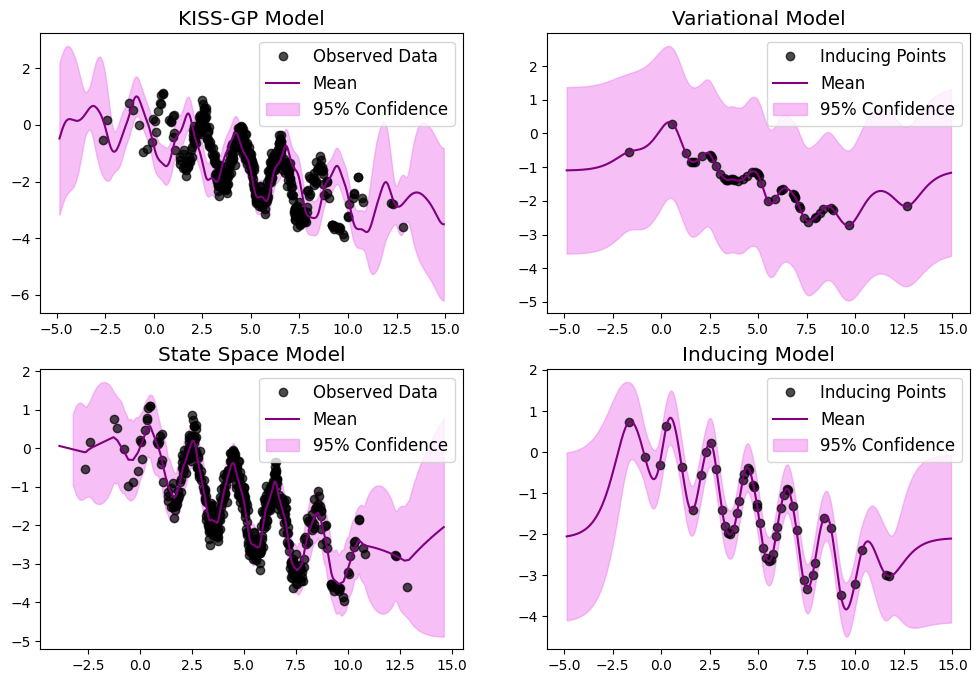

In [48]:
# Initalize plot
plt.style.use('default')
# Create a figure and a set of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Find min and max value of training set
min_value, max_value = min(x_train_wiggle), max(x_train_wiggle)
# Create points between min and max values
x_plot = torch.linspace(min_value-1, max_value+1, 1000)


# KISS-GP
# Evaluate on plot values
#prediction = predict(KISSGP_model_wiggle, KISSGP_likelihood_wiggle, x_plot)
#mean_KISSGP = prediction.mean
#var_KISSGP = prediction.variance
#lower_bound_KISSGP = mean_KISSGP-(1.96*(np.sqrt(var_KISSGP)))
#upper_bound_KISSGP = mean_KISSGP+(1.96*(np.sqrt(var_KISSGP)))
#ax[0,0].plot(training_x, training_y, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
#ax[0,0].plot(x_plot.detach().numpy(), mean_KISSGP.detach().numpy(), 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
#ax[0,0].fill_between(x_plot.detach().numpy(), lower_bound_KISSGP.detach().numpy(),
#                upper_bound_KISSGP.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
#ax[0,0].set_title("KISS-GP Model", fontsize="x-large")
#ax[0,0].legend(loc = "best", fontsize="large")


KISSGP_model_wiggle.eval(), KISSGP_likelihood_wiggle.eval()
# Evaluate on plot values
prediction = KISSGP_likelihood_wiggle(KISSGP_model_wiggle(x_plot))
KISSGP_model_wiggle.train(), KISSGP_likelihood_wiggle.train()
mean = prediction.mean
variance = prediction.variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Initalize plot
  plt.style.use('default')
  _, ax = plt.subplots(1, 1)

  # Confidence region
  lower_bound = mean-(1.96*(np.sqrt(variance)))
  upper_bound = mean+(1.96*(np.sqrt(variance)))

  ax[0,0].plot(x_train.detach().numpy(), y_train.detach().numpy(), 'ko', label='Observed Data', alpha = 0.7)
  # Plot predictive means
  ax[0,0].plot(x_plot.detach().numpy(), mean.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[0,0].fill_between(x_plot.detach().numpy(), lower_bound.detach().numpy(),
                  upper_bound.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[0,0].set_title(title)
  ax[0,0].legend(loc = "best")






# Variational Model
trained_variational_points_x = variational_model_wiggle.variational_strategy.inducing_points
trained_variational_points_y = predict(variational_model_wiggle, variational_likelihood_wiggle,
                                     trained_variational_points_x) # predict is defined in utils/functions.ipynb¨

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Evaluate on plot values
  prediction = predict(variational_model_wiggle, variational_likelihood_wiggle, x_plot)
  mean_variational = prediction.mean
  var_variational = prediction.variance
  lower_bound_variational = mean_variational-(1.96*(np.sqrt(var_variational)))
  upper_bound_variational = mean_variational+(1.96*(np.sqrt(var_variational)))
  ax[0,1].plot(trained_variational_points_x.numpy(), trained_variational_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[0,1].plot(x_plot.detach().numpy(), mean_variational.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[0,1].fill_between(x_plot.detach().numpy(), lower_bound_variational.detach().numpy(),
                  upper_bound_variational.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[0,1].set_title("Variational Model", fontsize="x-large")
  ax[0,1].legend(loc = "best", fontsize="large")





# Find min and max value of training set
temporal_order = jnp.argsort(x_test_wiggle.numpy())
x_test_order = x_test_wiggle.numpy()[temporal_order]
lower_bound_SS = ssop_posterior_mean_wiggle-(1.96*(np.sqrt(ssop_posterior_var_wiggle)))
upper_bound_SS = ssop_posterior_mean_wiggle+(1.96*(np.sqrt(ssop_posterior_var_wiggle)))
ax[1,0].plot(training_x, training_y, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
ax[1,0].plot(x_test_order, ssop_posterior_mean_wiggle, 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
ax[1,0].fill_between(x_test_order, lower_bound_SS,
                upper_bound_SS, alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
ax[1,0].set_title("State Space Model", fontsize="x-large")
ax[1,0].legend(loc = "best", fontsize="large")



# Inducing Model
trained_inducing_points_x = inducing_model_wiggle.covar_module.inducing_points
trained_inducing_points_y = predict(inducing_model_wiggle, inducing_likelihood_wiggle,
                                     trained_inducing_points_x) # predict is defined in utils/functions.ipynb¨

inducing_model_wiggle.eval(), inducing_likelihood_wiggle.eval()
# Evaluate on plot values
prediction = inducing_likelihood_wiggle(inducing_model_wiggle(x_plot))
inducing_model_wiggle.train(), inducing_likelihood_wiggle.train()
mean_inducing = prediction.mean
var_inducing = prediction.variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  lower_bound_inducing = mean_inducing-(1.96*(np.sqrt(var_inducing)))
  upper_bound_inducing = mean_inducing+(1.96*(np.sqrt(var_inducing)))
  ax[1,1].plot(trained_inducing_points_x.numpy(), trained_inducing_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[1,1].plot(x_plot.detach().numpy(), mean_inducing.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[1,1].fill_between(x_plot.detach().numpy(), lower_bound_inducing.detach().numpy(),
                  upper_bound_inducing.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[1,1].set_title("Inducing Model", fontsize="x-large")
  ax[1,1].legend(loc = "best", fontsize="large")


plt.savefig("models_wiggle.pdf")

# Plot The Training Times

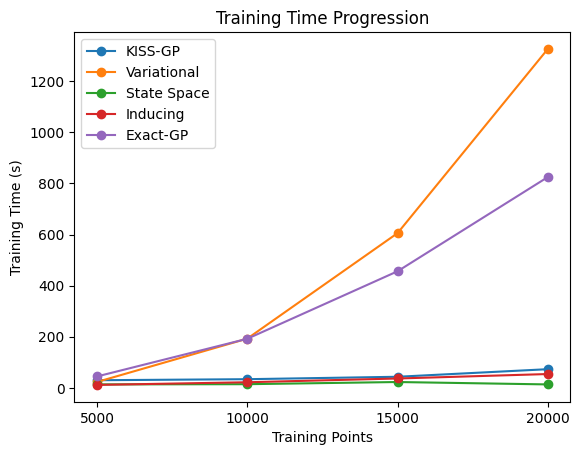

In [52]:
# Plot each array of training times
plt.plot(training_times_KISSGP, marker='o', label='KISS-GP')
plt.plot(training_times_variational, marker='o', label='Variational')
#plt.plot(training_times_SSPY, marker='o', label='State Space (PY)')
plt.plot(training_times_SSJX, marker='o', label='State Space')
plt.plot(training_times_inducing, marker='o', label='Inducing')
plt.plot(training_times_exact, marker='o', label='Exact-GP')

# Add labels and title
plt.xlabel('Training Points')
plt.ylabel('Training Time (s)')
plt.title('Training Time Progression')

plt.xticks(range(len(sizes_list)), sizes_list)


# Add a legend to explain which line corresponds to which array
plt.legend()

# Show the plot
plt.savefig("training_comparison.pdf")
plt.show()